In [25]:
%matplotlib inline
import torch
import torch.nn.utils.prune as prune
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")
from tqdm import tqdm

import config
from graph_models import FullGraphModel
from complete_training_data_processing import CompleteModelsDataProcessor
from utils import (
    clean_model_outputs, 
    get_image_paths, 
    get_iteration_number, 
    initialize_results_df, 
    select_random_images, 
    update_results_df, 
    update_running_loss, 
    plot_results
)

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
dtype = torch.float32

prune_frac = 0.01

In [26]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=config.DEVICE,
    num_classes=len(config.CLASSES),
).to(device)
criterion = CrossEntropyLoss()

In [27]:
checkpoint = torch.load(
    "models/model_2024-05-20 03:41:43.pth", map_location=device_type
    )
model.load_state_dict(checkpoint["model"])
torch.set_grad_enabled(False)
model.eval()
# prune.random_unstructured(
#     model.connectome, name="edge_weight_multiplier", amount=prune_frac
# )

FullGraphModel(
  (connectome): TrainableEdgeConv()
  (final_fc): Linear(in_features=1, out_features=2, bias=True)
)

  0%|          | 0/212 [00:00<?, ?it/s]

100%|██████████| 212/212 [16:03<00:00,  4.54s/it]


Finished testing with loss 184172.95529650743 and accuracy 0.4793632075471698.


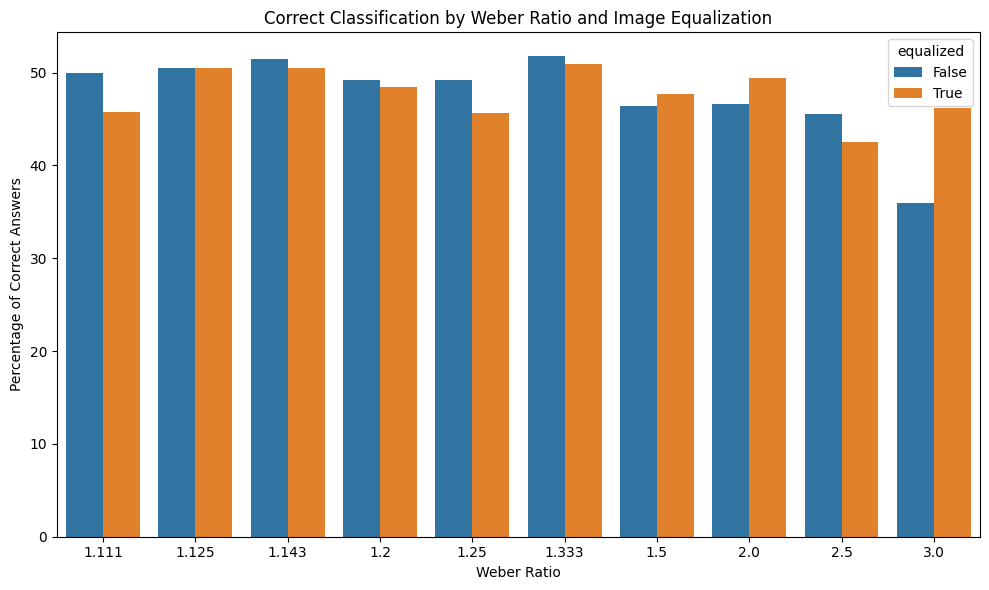

In [28]:
# test
batch_size = config.batch_size

testing_images = get_image_paths(
    config.TESTING_DATA_DIR, config.small, config.small_length
)
already_selected_testing = []
total_correct, total, running_loss = 0, 0, 0.0
test_results = initialize_results_df()

iterations = get_iteration_number(len(testing_images), batch_size)
for _ in tqdm(range(iterations)):
    batch_files, already_selected_testing = select_random_images(
        testing_images, batch_size, already_selected_testing
    )
    images, labels = data_processor.get_data_from_paths(batch_files)
    inputs, labels = data_processor.process_batch(images, labels)
    inputs = inputs.to(config.DEVICE)

    out = model(inputs)
    loss = criterion(out, labels)

    # Calculate run parameters
    outputs, predictions, labels_cpu, correct = clean_model_outputs(out, labels)
    test_results = update_results_df(
        test_results, batch_files, outputs, predictions, labels_cpu, correct
    )
    running_loss += update_running_loss(loss, inputs)
    total += batch_size
    total_correct += correct.sum()

final_plots = plot_results(test_results, plot_types=config.plot_types)

print(
    f"Finished testing with loss {running_loss / total} and "
    f"accuracy {total_correct / total}."
)